## **Building Multi-Agent Systems (MaS) with Azure AI Agent Service (single-Agent) + Semantic Kernel Agent Framework (Experimental) and Autogen v0.4**

In this notebook, we'll learn how to orchestrate our these single agents (cloud-managed via Azure AI Agent Service) by leveraging both the Semantic Kernel and AutoGen frameworks.

> **Note:** The [Semantic Kernel (SK) Agent Framework](https://learn.microsoft.com/en-us/semantic-kernel/frameworks/agent/agent-architecture?pivots=programming-language-csharp) is currently in preview and may change.

> If you need an in-depth hands-on learning lab about AutoGen and Semantic Kernel agentic frameworks, please visit this GitHub repo: https://github.com/pablosalvador10/gbbai-agent-architecture-lab 

#### **Refresh key Concepts Before gettin started:**

**My Formula (and Mental Model) for Building MaS**

```text
Multi-Agent Architecture = Σ (Production-Ready Single Agents (with tools, memory, traceability, and isolated execution)) + Preferred Framework (Semantic Kernel, AutoGen, etc.)
```

Always start by breaking down the problem into its fundamental components. Identify the decoupled, modular functions that need to be developed, and then design and build the system from a high-level perspective down to the low-level details. In other words:

+ *1. First, build single agents:* Ensure that individual agents are scalable and work reliably for the identified specialized task. Leverage Azure AI Agent Service.

- *2. Then, establish connections between agents, if needed:* Begin constructing inter-agent connections as add-on capabilities. This enables agents to collaborate on tasks—either by directly negotiating or by being indirectly guided toward a common goal. This approach will define your overall architecture and design pattern.

**Why Start with Single Agents?**: The `Azure AI Agent Service` makes it straightforward to design agents that are robust, context-aware, and capable of achieving specific goals autonomously. Once these agents successfully handle their tasks as singletons, you can gradually expand them into more complex multi-agent architectures.

**But how do we enable our agents to talk to each other?** In the human world, we might simply put people in the same room to converse naturally. Similarly, agents can be set up to interact and collaborate in virtual rooms, exchanging messages and forming the foundation for advanced, event-driven agent architectures. To achieve this, you can either build your code from scratch or leverage an existing framework. There are many options available, but at Microsoft, we are focusing on two open-source SDKs.

**Enable Agent Communication with a Framework: Semantic Kernel or AutoGen**

Both frameworks enable agents to perform tasks using modular “skills” – conceptually equivalent to tools – but they differ in focus and design:

- **AutoGen**  
  - **Purpose:** Primarily research- and prototyping-focused, AutoGen allows rapid creation of multi-agent systems with a flexible, event-driven architecture.  
  - **Skills as Tools:** In AutoGen, agents are equipped with “tools” that they invoke directly during conversations, streamlining experimentation and innovative agent behavior.  
  - **Use Case:** Ideal for early-stage development, proof-of-concept experiments, and exploring cutting-edge agentic patterns.

- **Semantic Kernel**  
  - **Purpose:** Designed for enterprise-grade, production-ready applications, Semantic Kernel emphasizes stability and structured integration.  
  - **Plugin Skills:** Instead of “tools,” Semantic Kernel wraps functionalities as plugins or “skills” – native or semantically defined functions that are conceptually equivalent to AutoGen’s tools. This approach supports deeper orchestration and long-running, stateful processes.  
  - **Use Case:** Best suited for applications that require robust support, seamless production deployment, and advanced workflow management.
  
So it seems to make sense now, correct? We break down the problem, identify the different agent needs that must be part of the solution, and then focus on building a robust, reliable single-agent system first. Next, we use your preferred framework to orchestrate these single agents to resolve more complex tasks.

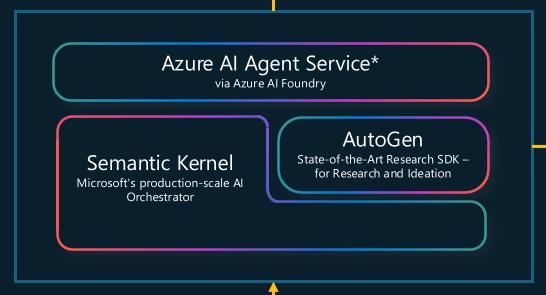

## **1. How-to create MaS with Autogen (Framework) + Azure AI Agent Service (Managed Agents)**

**Scenario**

Imagine you're a content creator aiming to streamline your blogging process. Your latest blog post is about **Machine Learning**, and you want to automate the research, writing, and saving steps using a multi-agent system powered by Azure AI Agent Service.

To accomplish this, you set up a round-robin orchestration with three specialized agents that each handle a distinct task:

- **Bing Search Agent**:  
  This agent acts as a search expert. When given a query, it leverages a Bing Grounding Tool to fetch relevant information from the web. For this exercise, it is tasked with finding answers to three essential questions:  
  1. What is Machine Learning?  
  2. What is the difference between AI and ML?  
  3. What is the history of Machine Learning?  

- **Write Agent**:  
  Once the Bing Search Agent has gathered the necessary information, the Write Agent takes over. This agent is a seasoned blog writer who uses the search results to craft an engaging and informative blog post about machine learning. The goal is to ensure the content is clear, comprehensive, and appealing to both novices and experts.

- **Save Blog Content Agent**:  
  After the blog post is written, the Save Blog Content Agent is responsible for saving the content. Using a Code Interpreter Tool, it generates and executes code to save the blog as a markdown file (e.g., `blog-YYMMDDHHMMSS.md`). When the file is successfully saved, this agent responds with **"Saved"** and provides a download link for the file.

The orchestration is controlled by a **Round-Robin Group Chat** that continues to cycle through these agents until a termination condition is met. The process will stop either when the **"Saved"** message is returned or when a maximum number of messages (10 in this example) have been exchanged.


In [1]:
# Please uncomment as needed
#!pip install tiktoken==0.8.0

#### **Before we get into multi-agent orchestration, let's see how we can orchestrate one single agent (Azure AI Agent Service) with Autogen.**

In [2]:
# imports
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.conditions import MaxMessageTermination, TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from azure.ai.projects import AIProjectClient
from azure.ai.projects.models import BingGroundingTool, CodeInterpreterTool
from autogen_agentchat.messages import TextMessage
from autogen_core import CancellationToken
import time
import os
from azure.core.exceptions import HttpResponseError

In [3]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

In [4]:
#!pip install autogen_agentchat --upgrade
# Import the AutoGen library
import autogen_agentchat as ag

# Print the version of the AutoGen library
print(f"We are using the following autogen_agentchat library version: {ag.__version__}")

We are using the following autogen_agentchat library version: 0.4.1


#### **🤖 Creating The Bing Agent in Azure AI Agent Service**

In [5]:
# Initialize the Azure OpenAI Chat Completion client.
az_model_client = AzureOpenAIChatCompletionClient(
    azure_deployment=os.environ.get("AZURE_OPENAI_MODEL_NAME_DEPLOYMENT_ID"),
    model=os.environ.get("AZURE_OPENAI_MODEL_NAME_DEPLOYMENT_ID"),
    api_version=os.environ.get("AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT"),
    api_key=os.environ.get("AZURE_OPENAI_KEY"),
)

# Set your connection string (replace with your actual connection string)
project_connection_string = os.getenv("PROJECT_CONNECTION_STRING")

# Create the project client
project_client = AIProjectClient.from_connection_string(
    conn_str=project_connection_string, credential=DefaultAzureCredential()
)

In [6]:
def create_bing_agent():
    bing_connection = project_client.connections.get(
        connection_name=os.environ.get("BING_CONNECTION_NAME")
    )
    conn_id = bing_connection.id
    if not conn_id:
        raise ValueError("BING_CONNECTION_NAME environment variable is not set.")

    # Initialize the Bing grounding tool
    bing = BingGroundingTool(connection_id=conn_id)
    agent = project_client.agents.create_agent(
        model=os.environ.get("AZURE_OPENAI_MODEL_NAME_DEPLOYMENT_ID"),
        name="my-assistant-bing-agent",
        instructions="""        
                You are a web search agent whose main responsibility is to provide accurate, relevant, and real-time information in response to user queries.
                Your only tool is search_tool – use it exclusively to find and verify data from reliable web sources.
                It is crucial that your responses are always grounded in the search results, and you must clearly reference the websites or sources used.
                You are allowed to make only one search call at a time. Once you have the results, do not perform additional calculations.
            """,
        tools=bing.definitions,
        headers={"x-ms-enable-preview": "true"},
    )
    print(f"Created agent with ID: {agent.id}")
    return agent


# create_bing_agent
agent = create_bing_agent()
print("Agent ID: ", agent.id)

Created agent with ID: asst_hIh1w3ykYXBTy2RluhsI7qy4
Agent ID:  asst_hIh1w3ykYXBTy2RluhsI7qy4


You can check the Agent in AI foundry ! 

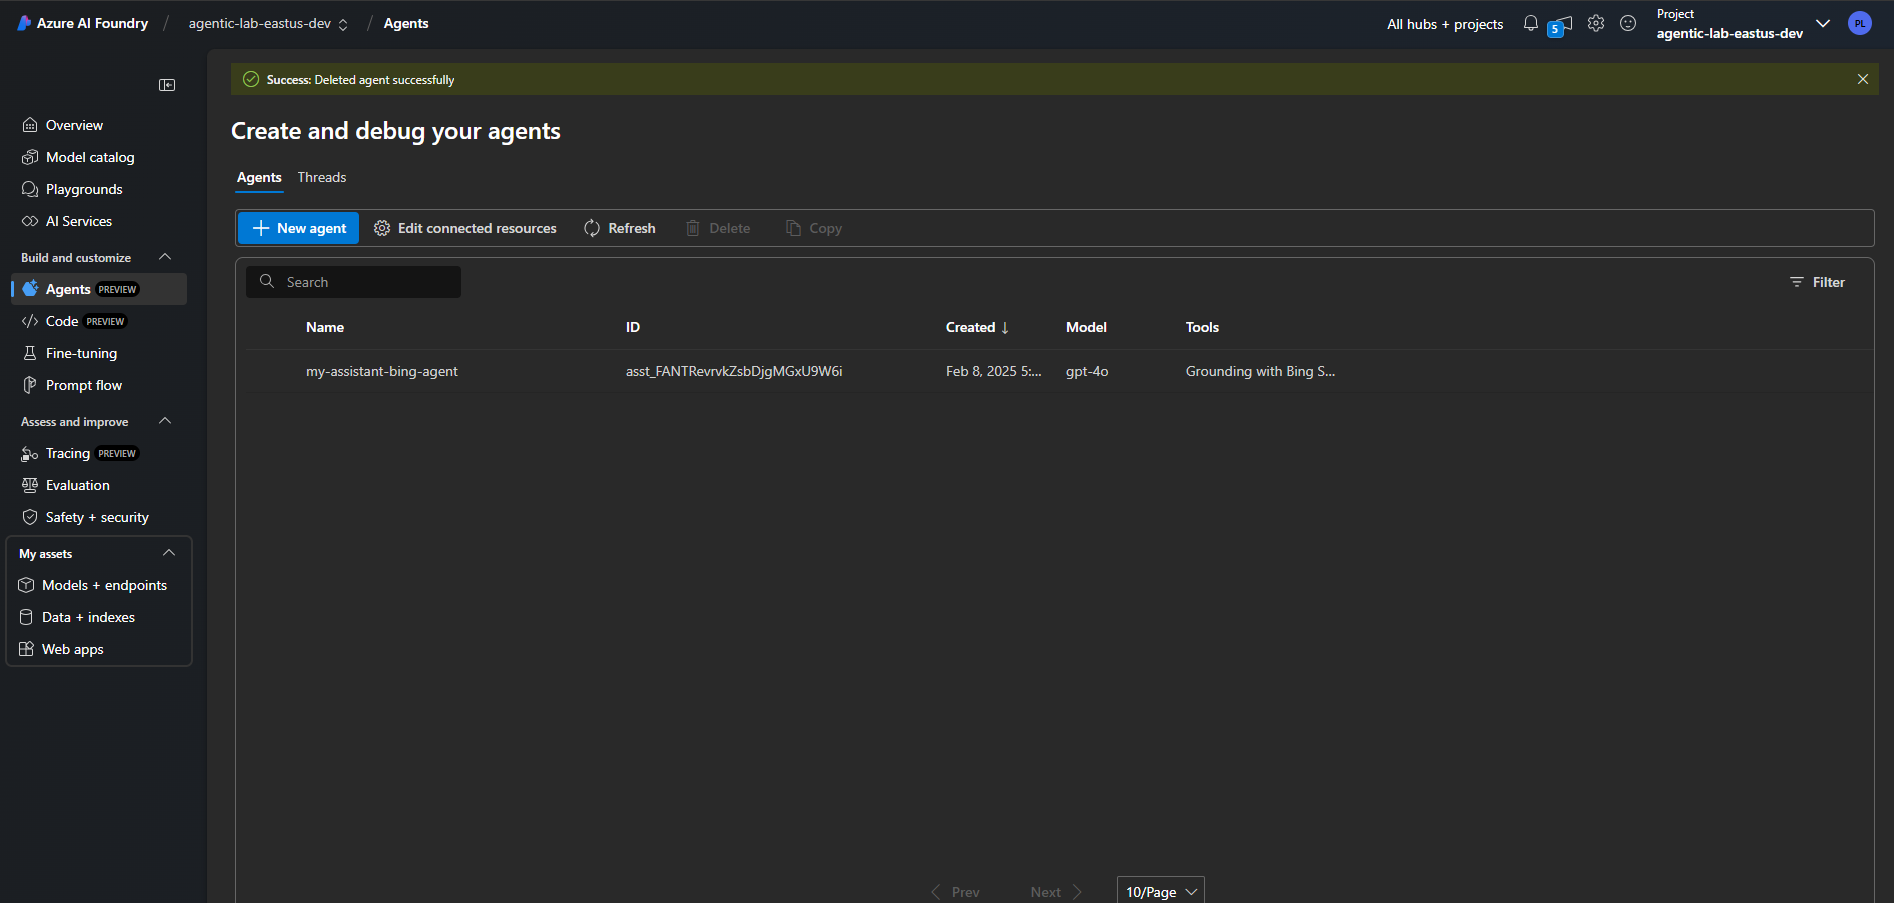

Awesome! Agent created. You can reuse the agent by calling:



In [7]:
big_web_ai_agent = project_client.agents.get_agent(
    assistant_id="asst_FANTRevrvkZsbDjgMGxU9W6i"
)  # Replace with your assistant ID.

How easy it is to create reusable cloud-based component "agents" in azure foundry that allow us to focus on what matters: the tooling, the prompt engineering, the model selection and the orchestration. Let's wrap up the azure agent in an asynchronous function to pass it as a tool (translate to skill) to agents in AutoGen, allowing them to call the tool, which will then run our agent.

In [8]:
async def web_ai_agent(query: str) -> str:
    """
    Search the internet for real-time information based on the given query.

    Args:
        query (str): The search query.

    Returns:
        str: The text content retrieved from the first message of the agent's response.
    """

    print("Starting Bing search for Azure AI Agent Service...")
    project_client = AIProjectClient.from_connection_string(
        conn_str=project_connection_string, credential=DefaultAzureCredential()
    )

    with project_client:
        try:
            # Get the Bing search agent
            big_web_ai_agent = project_client.agents.get_agent(
                assistant_id="asst_FANTRevrvkZsbDjgMGxU9W6i"
            )  # Replace with your assistant ID
        except Exception as e:
            print(f"Failed to get Bing search agent: {e}")
            big_web_ai_agent = create_bing_agent()

        # Create a communication thread and send the user's query.
        thread = project_client.agents.create_thread()
        print(f"Created thread with ID: {thread.id}")

        project_client.agents.create_message(
            thread_id=thread.id,
            role="user",
            content=query,
        )
        print("User message sent.")

        # Run the agent process.
        run = project_client.agents.create_and_process_run(
            thread_id=thread.id, assistant_id=big_web_ai_agent.id
        )
        print(f"Run finished with status: {run.status}")

        # Create and process the run (combines creation + processing)
        try:
            tool_run = project_client.agents.create_and_process_run(
                thread_id=thread.id, assistant_id=big_web_ai_agent.id
            )
            print(f"Run created with initial status: {tool_run.status}")
        except HttpResponseError as e:
            print(f"Failed to create and process run: {e}")
            return

        # Polling to check the run status until completion
        try:
            while tool_run.status in ["queued", "in_progress", "requires_action"]:
                print(f"Current run status: {tool_run.status}")
                time.sleep(2)  # Wait for 2 seconds before checking again
                tool_run = project_client.agents.get_run(
                    thread_id=thread.id, run_id=tool_run.id
                )
                print(f"Updated run status: {tool_run.status}")
        except Exception as e:
            print("Error while polling run status.")
            return

        if run.status == "failed":
            print(f"Run failed with error: {run.last_error}")
            raise RuntimeError(f"Agent run failed: {run.last_error}")

        # Retrieve the result message BEFORE deleting the agent.
        messages = project_client.agents.list_messages(thread_id=thread.id)
        try:
            result_text = messages["data"][0]["content"][0]["text"]["value"]
        except (KeyError, IndexError) as e:
            raise RuntimeError("Failed to parse the result message.") from e

        print(f"Retrieved message: {result_text}")

    return result_text


# Define the Bing search agent using the web_ai_agent tool.
bing_search_agent = AssistantAgent(
    name="assistant",
    model_client=az_model_client,
    tools=[web_ai_agent],
    system_message="Use tools to solve tasks.",
)


async def assistant_run() -> None:
    """
    Runs the assistant agent to answer a query using the Bing search tool.
    """
    response = await bing_search_agent.on_messages(
        [
            TextMessage(
                content="What day is today? Please ensure your information is always based on real-time data, mention the source of data.",
                source="user",
            )
        ],
        cancellation_token=CancellationToken(),
    )
    print(response.chat_message)
    return response


response = await assistant_run()

c:\Users\pablosal\AppData\Local\anaconda3\envs\tech-connect-agentic-lab\lib\site-packages\autogen_agentchat\agents\_assistant_agent.py:330: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-05-13. Model mapping may be incorrect.
  result = await self._model_client.create(


Starting Bing search for Azure AI Agent Service...
Created thread with ID: thread_5XHk1svrKz4ShbbWMEjo8AUC
User message sent.
Run finished with status: completed
Run created with initial status: completed
Retrieved message: Today's date is February 11, 2025【0†source】【1†source】.
source='assistant' models_usage=None content="Today's date is February 11, 2025【0†source】【1†source】." type='ToolCallSummaryMessage'


In [9]:
import pprint

pprint.pprint(response.chat_message.content)

"Today's date is February 11, 2025【0†source】【1†source】."


#### **It's time for streamline your blogging process. Let's build our first multi-agent system..**

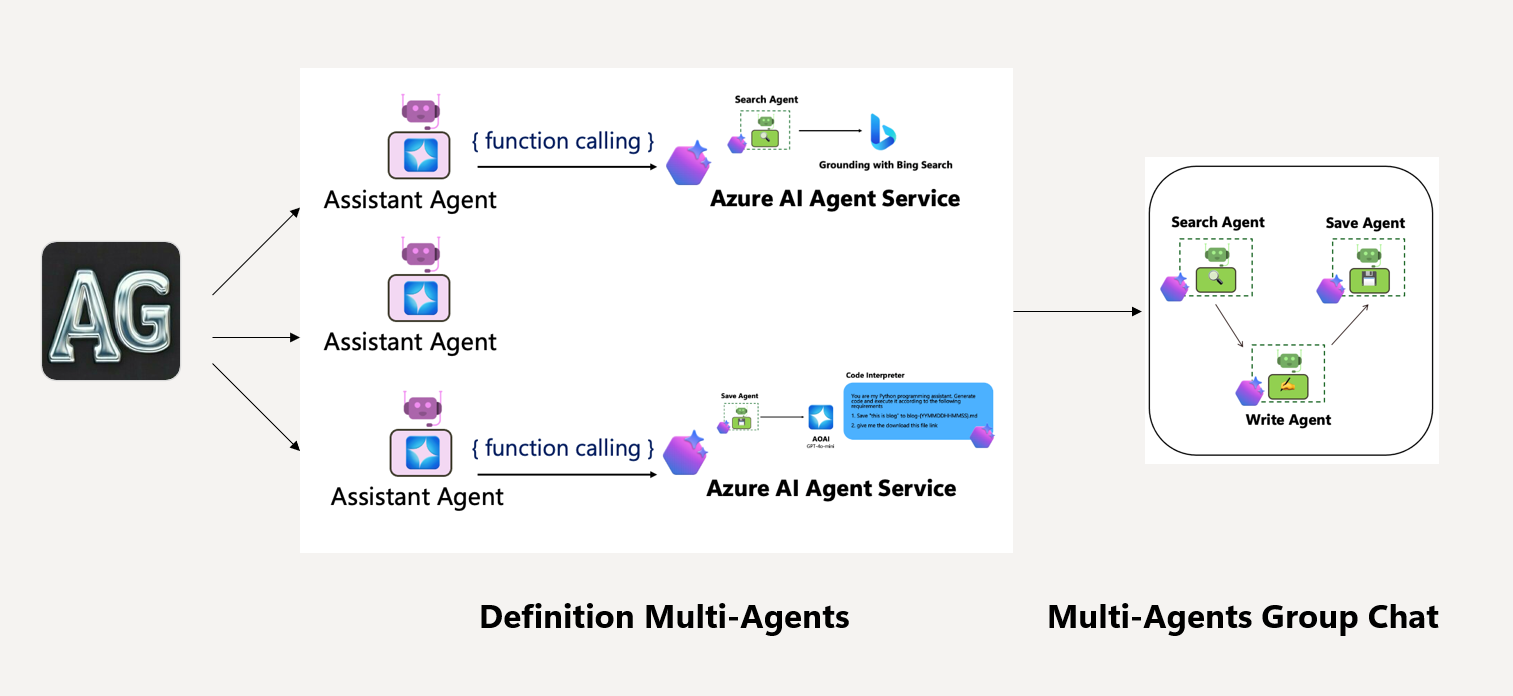

#### **🤖 Creating The Researcher Agent**

In [10]:
researcher_bing_search_agent = AssistantAgent(
    name="bing_search_agent",
    model_client=az_model_client,
    tools=[web_ai_agent],
    system_message=(
        "You are an expert researcher with deep expertise in web investigations. Always use tools to find relevant knowledge "
        "Your role is to thoroughly analyze complex topics and methodically retrieve accurate, real-time information. "
        "Ensure every piece of data is validated against credible sources and clearly referenced. "
        "Approach inquiries with a rigorous, detail-oriented mindset to deliver comprehensive and reliable results. Always use tools to find relevant knowledge"
    ),
)

#### **🤖 Creating The Editor (Saves blog) Agent**

In [11]:
# create the Azure AI agent (code interpreter agent)
def create_editor_agent():
    # Initialize the Code Interpreter tool.
    code_interpreter = CodeInterpreterTool()

    # Create an agent with the Code Interpreter tool.
    agent = project_client.agents.create_agent(
        model=os.environ.get("AZURE_OPENAI_MODEL_NAME_DEPLOYMENT_ID"),
        name="my-assistant-code-editor-agent",
        instructions="""        
            You are a code interpreter agent with a deep understanding of software development.
            Your primary responsibility is to analyze, interpret, and provide precise coding suggestions.
            Use the Code Interpreter tool to interact with code effectively, ensuring your recommendations are well-founded and accurate.
            Reference code snippets and documentation as needed to support your answers.
        """,
        tools=code_interpreter.definitions,
    )
    print(f"Created Editor agent with ID: {agent.id}")
    return agent


# Create Bing agent
create_editor_agent = create_editor_agent()

Created Editor agent with ID: asst_9Eud4MQUg1xojbbt3CvcOT0i


In [12]:
import datetime
import os
import asyncio


async def save_blog_agent(blog_content: str) -> str:
    """
    Uses the Code Interpreter for Azure AI Agent Service to generate and execute code that saves a blog post.

    The agent generates Python code to save the provided blog content into a timestamped markdown file
    in a specified directory and returns a confirmation ("Saved") if the operation succeeds.

    Args:
        blog_content (str): The blog post content to be saved.

    Returns:
        str: "Saved" if the blog content was successfully saved.
    """
    print(
        "Starting Code Interpreter for Azure AI Agent Service for saving blog post..."
    )

    # Define the target directory.
    target_dir = os.path.join(os.getcwd(), "utils", "outputs", "articles")
    os.makedirs(target_dir, exist_ok=True)
    print(f"Target directory ensured: {target_dir}")

    project_client = AIProjectClient.from_connection_string(
        conn_str=project_connection_string, credential=DefaultAzureCredential()
    )

    with project_client:
        # Attempt to retrieve the editor agent. If not available, create one.
        try:
            editor_agent = project_client.agents.get_agent(
                assistant_id="asst_HQFohRJY5vvJaPEe0chF1dOa"
            )
            print(f"Found existing Editor agent with ID: {editor_agent.id}")
        except Exception as e:
            print(f"Editor agent not found. Creating a new editor agent. Error: {e}")
            editor_agent = create_editor_agent()

        # Create a communication thread.
        thread = project_client.agents.create_thread()
        print(f"Created thread with ID: {thread.id}")

        # Construct the message with task instructions.
        message_content = (
            "You are my Python programming assistant. Generate Python code to save the following blog content:\n\n"
            f"{blog_content}\n\n"
            "Execute with these requirements:\n"
            "1. Save the blog content to a file named blog-<YYYYMMDDHHMM>.md using the current timestamp (up to minutes) to avoid duplicates.\n"
            f"   The file must be saved in the directory: {target_dir}\n"
            "2. Provide a download link for this file that reflects its correct absolute path."
        )
        project_client.agents.create_message(
            thread_id=thread.id,
            role="user",
            content=message_content,
        )
        print("User message sent.")

        # Create and process the agent run.
        try:
            run = project_client.agents.create_and_process_run(
                thread_id=thread.id, assistant_id=editor_agent.id
            )
            print(f"Initial run created with status: {run.status}")
        except HttpResponseError as e:
            print(f"Failed to create and process run: {e}")
            raise RuntimeError(f"Failed to create and process run: {e}")

        # Poll the run status until completion.
        try:
            current_run = run
            while current_run.status in ["queued", "in_progress", "requires_action"]:
                print(f"Current run status: {current_run.status}")
                await asyncio.sleep(2)
                current_run = project_client.agents.get_run(
                    thread_id=thread.id, run_id=current_run.id
                )
                print(f"Updated run status: {current_run.status}")
        except Exception as e:
            print("Error while polling run status.")
            raise RuntimeError("Error while polling run status.") from e

        if current_run.status == "failed":
            print(f"Run failed with error: {current_run.last_error}")
            raise RuntimeError(f"Agent run failed: {current_run.last_error}")

        # Retrieve messages from the thread.
        try:
            messages = project_client.agents.list_messages(thread_id=thread.id)
            print("Retrieved messages from thread.")
        except Exception as e:
            print("Failed to retrieve messages.")
            raise RuntimeError("Failed to retrieve messages.") from e

        # Parse and log the assistant's message.
        try:
            assistant_message = messages["data"][0]["content"][0]["text"]["value"]
            print(f"Assistant's message: {assistant_message}")
        except (KeyError, IndexError) as e:
            print("Failed to parse the assistant's message.")
            raise RuntimeError("Failed to parse the assistant's message.") from e

        # Save any generated files using the captured target directory.
        try:
            timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M")
            file_saved = False

            if "file_path_annotations" in messages:
                for file_annotation in messages.get("file_path_annotations", []):
                    file_text = file_annotation.get("text")
                    file_path_info = file_annotation.get("file_path")
                    if file_text and file_path_info:
                        file_name = f"blog-{timestamp}.md"
                        project_client.agents.save_file(
                            file_id=file_path_info.get("file_id"),
                            file_name=file_name,
                            target_dir=target_dir,
                        )
                        print(f"Saved file: {file_name} at {target_dir}")

                        # Verify that the file exists in the target directory.
                        full_file_path = os.path.join(target_dir, file_name)
                        if os.path.exists(full_file_path):
                            print(f"Verified file exists at {full_file_path}")
                        else:
                            print(
                                f"File {full_file_path} not found after save operation."
                            )
                        file_saved = True

                if not file_saved:
                    print(
                        "No file annotations found in messages to save the blog content."
                    )
            else:
                print("file_path_annotations key not found in messages.")
        except Exception as e:
            print("Failed to save generated files.")
            raise RuntimeError("Failed to save generated files.") from e

    print("Blog post saved successfully. Returning 'Saved'.")
    return "Saved"

In [13]:
save_blog_content_agent = AssistantAgent(
    name="save_blog_content_agent",
    model_client=az_model_client,
    tools=[save_blog_agent],
    system_message="""
        You are an expert blog content management agent. Your role is to accurately save and manage blog content. 
        When the blog content is successfully saved, respond with the exact word 'Saved'.
        Use the provided tool exclusively for saving operations and verify that all content is correctly stored before confirming.
    """,
)

#### **🤖 Creating The Writer Agent**

In [14]:
write_agent = AssistantAgent(
    name="write_agent",
    model_client=az_model_client,
    system_message="""
        You are an experienced blog writer with a deep understanding of content creation based on real-time Bing search results.
        Your task is to craft engaging, informative, and well-structured blog posts using the data retrieved from Bing searches.
        Ensure that your writing is clear, comprehensive, and always grounded in the referenced sources.
    """,
)

#### 🎉 **Let's get the agents in the same room. Some rules..tell them how-to chat and when to stop..somehow.**

In [15]:
# Define termination conditions:
# 1. Terminate if any agent outputs the keyword "Saved".
text_termination = TextMentionTermination("Saved")
# 2. Terminate if 10 messages have been exchanged.
max_message_termination = MaxMessageTermination(10)
# Combine both conditions: The process will stop if either condition is met.
termination = text_termination | max_message_termination

# Create a round-robin group chat with the designated agents:
# - bing_search_agent: Performs web searches using Bing.
# - write_agent: Crafts blog content based on search results.
# - save_blog_content_agent: Saves the final blog content.
reflection_team = RoundRobinGroupChat(
    participants=[bing_search_agent, write_agent, save_blog_content_agent],
    termination_condition=termination,
)

# Define the task prompt with clear, detailed instructions.
task_prompt = (
    "I am writing a comprehensive blog post about machine learning. Please complete the following steps:\n"
    "1. Perform a search for: 'What is Machine Learning?'\n"
    "2. Perform a search for: 'What is the difference between AI and ML?'\n"
    "3. Perform a search for: 'What is the history of Machine Learning?'\n\n"
    "Using the gathered information, collaboratively write an engaging and well-structured blog post. "
    "Once the blog content is finalized, save it."
)

# Execute the round-robin group chat and stream the messages to the console.
await Console(reflection_team.run_stream(task=task_prompt))

---------- user ----------
I am writing a comprehensive blog post about machine learning. Please complete the following steps:
1. Perform a search for: 'What is Machine Learning?'
2. Perform a search for: 'What is the difference between AI and ML?'
3. Perform a search for: 'What is the history of Machine Learning?'

Using the gathered information, collaboratively write an engaging and well-structured blog post. Once the blog content is finalized, save it.


Starting Bing search for Azure AI Agent Service...
Created thread with ID: thread_WtVasJr2YovEG7GmEnpVzyhu
User message sent.
Run finished with status: completed
Run created with initial status: completed
Retrieved message: Machine Learning (ML) is a subset of artificial intelligence (AI) that involves training algorithms on data sets to create models capable of performing specific tasks without explicit programming by humans. These models can learn from data, identify patterns, and make decisions or predictions based on new data. There are different types of machine learning, including supervised learning, unsupervised learning, semi-supervised learning, and reinforcement learning【0†source】【1†source】【2†source】. Applications of ML include recommendation systems, fraud detection, speech recognition, and autonomous vehicles.
Starting Bing search for Azure AI Agent Service...
Created thread with ID: thread_JzVnhsXjQ7akworA8ra2JsdP
User message sent.
Run finished with status: completed
Run

---------- assistant ----------
[FunctionExecutionResult(content='Machine Learning (ML) is a subset of artificial intelligence (AI) that involves training algorithms on data sets to create models capable of performing specific tasks without explicit programming by humans. These models can learn from data, identify patterns, and make decisions or predictions based on new data. There are different types of machine learning, including supervised learning, unsupervised learning, semi-supervised learning, and reinforcement learning【0†source】【1†source】【2†source】. Applications of ML include recommendation systems, fraud detection, speech recognition, and autonomous vehicles.', call_id='call_1p3AysflsWZ3lClxaZQs4W3X'), FunctionExecutionResult(content='Artificial Intelligence (AI) is a broad field that encompasses the development of computer systems capable of performing tasks that would usually require human intelligence, such as reasoning, problem-solving, and understanding language. Machine 

TaskResult(messages=[TextMessage(source='user', models_usage=None, content="I am writing a comprehensive blog post about machine learning. Please complete the following steps:\n1. Perform a search for: 'What is Machine Learning?'\n2. Perform a search for: 'What is the difference between AI and ML?'\n3. Perform a search for: 'What is the history of Machine Learning?'\n\nUsing the gathered information, collaboratively write an engaging and well-structured blog post. Once the blog content is finalized, save it.", type='TextMessage'), ToolCallRequestEvent(source='assistant', models_usage=RequestUsage(prompt_tokens=259, completion_tokens=80), content=[FunctionCall(id='call_1p3AysflsWZ3lClxaZQs4W3X', arguments='{"query": "What is Machine Learning?"}', name='web_ai_agent'), FunctionCall(id='call_1I9n0pvzqI7FYLvnDBosU1mK', arguments='{"query": "What is the difference between AI and ML?"}', name='web_ai_agent'), FunctionCall(id='call_msmWHYA1ZYeCb00y2qB4pKL6', arguments='{"query": "What is the 

**🎉 Congrats, you have created a blog about ML - well your multi-agent system did for you. Let's repeat the scenario but with Semantic Kernel.** 

## **2. How-to create MaS with SK (Agentic Framework) + Azure AI Agent Service (Managed Agents)**


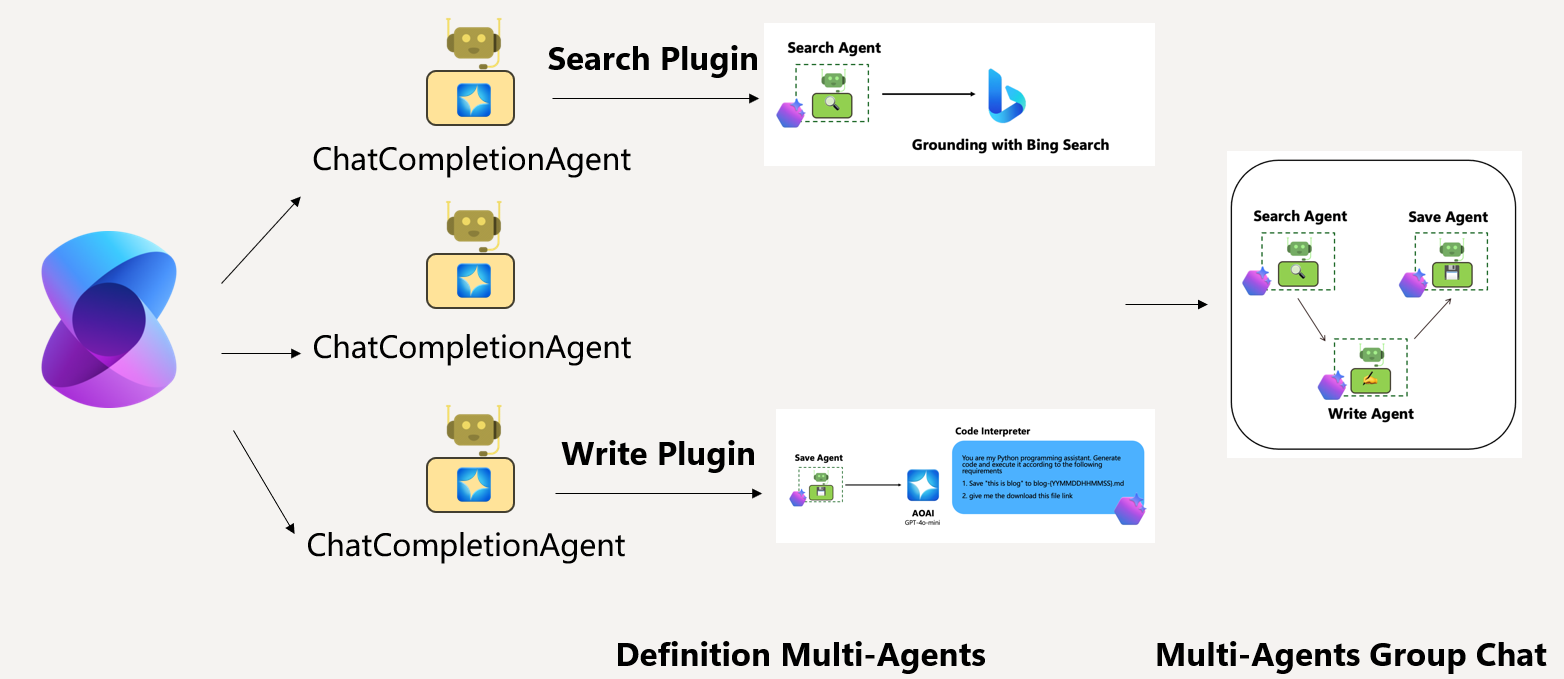

Same Scenario but different framework..SK uses a plugin-based multi-agent system orchestrated via a round-robin group chat. Same three agents work together to create and save a blog post about machine learning:

- **Bing Search Agent**:  
  Fetches answers for:
  1. What is Machine Learning?
  2. The difference between AI and ML.
  3. The history of Machine Learning.

- **Write Agent**:  
  Crafts a blog post using the search results.

- **Save Blog Content Agent**:  
  Saves the blog content as a timestamped markdown file (e.g., `blog-YYMMDDHHMMSS.md`) and returns **"Saved"** upon completion.

The orchestration stops when the **"Saved"** message is returned or after 10 message exchanges.

**AutoGen vs. Semantic Kernel (In a nutshell)**

Both frameworks enable agents to perform tasks using modular “skills” – conceptually equivalent to tools – but they differ in focus and design:

- **AutoGen**  
  - **Purpose:** Primarily research- and prototyping-focused, AutoGen allows rapid creation of multi-agent systems with a flexible, event-driven architecture.  
  - **Skills as Tools:** In AutoGen, agents are equipped with “tools” that they invoke directly during conversations, streamlining experimentation and innovative agent behavior.  
  - **Use Case:** Ideal for early-stage development, proof-of-concept experiments, and exploring cutting-edge agentic patterns.

- **Semantic Kernel**  
  - **Purpose:** Designed for enterprise-grade, production-ready applications, Semantic Kernel emphasizes stability and structured integration.  
  - **Plugin Skills:** Instead of “tools,” Semantic Kernel wraps functionalities as plugins or “skills” – native or semantically defined functions that are conceptually equivalent to AutoGen’s tools. This approach supports deeper orchestration and long-running, stateful processes.  
  - **Use Case:** Best suited for applications that require robust support, seamless production deployment, and advanced workflow management.

*In summary, while both frameworks provide agents with modular capabilities (whether called tools or plugins/skills), AutoGen leans toward rapid prototyping and experimental flexibility, whereas Semantic Kernel offers a more structured, enterprise-ready environment.*  

> If you need an in-depth hands-on learning lab about AutoGen and Semantic Kernel agentic frameworks, please visit this GitHub repo: https://github.com/pablosalvador10/gbbai-agent-architecture-lab 


In [16]:
import semantic_kernel as sk

#!pip install semantic-kernel --upgrade
print(f"We are using the following semantic_kernel library version: {sk.__version__}")

We are using the following semantic_kernel library version: 1.20.0


In [17]:
from semantic_kernel.agents import AgentGroupChat, ChatCompletionAgent
from semantic_kernel.agents.strategies.selection.kernel_function_selection_strategy import (
    KernelFunctionSelectionStrategy,
)
from semantic_kernel.connectors.ai.open_ai.services.azure_chat_completion import (
    AzureChatCompletion,
)
from semantic_kernel.contents.chat_message_content import ChatMessageContent
from semantic_kernel.contents.utils.author_role import AuthorRole
from semantic_kernel.functions.kernel_function_decorator import kernel_function
from semantic_kernel.functions.kernel_function_from_prompt import (
    KernelFunctionFromPrompt,
)
from semantic_kernel.kernel import Kernel

**Let's create the plugins as we need to add skils to our agents (what we called the tools in Autogen)**


In [18]:
import os
import datetime
import asyncio
from typing import Optional, Annotated

from azure.core.exceptions import HttpResponseError
from semantic_kernel.functions.kernel_function_decorator import kernel_function


class BlogAgentPlugin:
    """
    Plugin class for saving a blog post.

    This plugin generates and executes code to save the provided blog content into a
    timestamped markdown file. On success, it returns 'Saved'.
    """

    def __init__(
        self,
        agent_id: Optional[str] = None,
        project_connection_string: Optional[str] = None,
    ) -> None:
        print("BlogAgentPlugin initialized.")
        self.agent_id = (
            agent_id or "asst_HQFohRJY5vvJaPEe0chF1dOa"
        )  # Replace with your default assistant ID
        self.project_connection_string = project_connection_string or os.getenv(
            "PROJECT_CONNECTION_STRING"
        )

    @kernel_function(
        name="save_blog",
        description=(
            "Generates and executes code to save the provided blog content into a timestamped markdown file. "
            "The file is saved in a designated directory and returns 'Saved' upon success."
        ),
    )
    async def save_blog(
        self, blog_content: Annotated[str, "The blog post content to be saved."]
    ) -> Annotated[str, "Returns 'Saved' if the blog content was successfully saved."]:
        """Uses the Code Interpreter for Azure AI Agent Service to generate and execute code that saves a blog post."""
        print("Starting blog save operation...")
        target_dir = os.path.join(os.getcwd(), "utils", "outputs", "articles")
        os.makedirs(target_dir, exist_ok=True)
        print(f"Target directory ensured: {target_dir}")

        # Create a new client instance for this call.
        project_client = AIProjectClient.from_connection_string(
            conn_str=self.project_connection_string,
            credential=DefaultAzureCredential()
        )

        try:
            # Attempt to get the existing editor agent; if it fails, create a new one.
            try:
                editor_agent = project_client.agents.get_agent(
                    assistant_id=self.agent_id
                )
                print(f"Found existing Editor agent with ID: {editor_agent.id}")
            except Exception as e:
                print(f"Editor agent not found, creating new one. Error: {e}")
                editor_agent = create_editor_agent()  # Ensure this function is defined

            thread = project_client.agents.create_thread()
            print(f"Created thread with ID: {thread.id}")

            message_content = (
                "You are my Python programming assistant. Generate Python code to save the following blog content:\n\n"
                f"{blog_content}\n\n"
                "Execute with these requirements:\n"
                "1. Save the blog content to a file named blog-<YYYYMMDDHHMM>.md using the current timestamp to avoid duplicates.\n"
                f"   The file must be saved in the directory: {target_dir}\n"
                "2. Provide a download link for the file with its absolute path."
            )
            project_client.agents.create_message(
                thread_id=thread.id,
                role="user",
                content=message_content,
            )
            print("User message sent for blog saving.")

            try:
                run = project_client.agents.create_and_process_run(
                    thread_id=thread.id, assistant_id=editor_agent.id
                )
                print(f"Initial run created with status: {run.status}")
            except HttpResponseError as e:
                print(f"Failed to create and process run: {e}")
                raise RuntimeError(f"Failed to create and process run: {e}")

            try:
                current_run = run
                while current_run.status in [
                    "queued",
                    "in_progress",
                    "requires_action",
                ]:
                    print(f"Current run status: {current_run.status}")
                    await asyncio.sleep(2)
                    current_run = project_client.agents.get_run(
                        thread_id=thread.id, run_id=current_run.id
                    )
                    print(f"Updated run status: {current_run.status}")
            except Exception as e:
                print("Error while polling run status.")
                raise RuntimeError("Error while polling run status.") from e

            if current_run.status == "failed":
                print(f"Run failed with error: {current_run.last_error}")
                raise RuntimeError(f"Agent run failed: {current_run.last_error}")

            try:
                messages = project_client.agents.list_messages(thread_id=thread.id)
                print("Retrieved messages from thread.")
            except Exception as e:
                print("Failed to retrieve messages.")
                raise RuntimeError("Failed to retrieve messages.") from e

            try:
                assistant_message = messages["data"][0]["content"][0]["text"]["value"]
                print(f"Assistant's message: {assistant_message}")
            except (KeyError, IndexError) as e:
                print("Failed to parse the assistant's message.")
                raise RuntimeError("Failed to parse the assistant's message.") from e

            try:
                timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M")
                file_saved = False

                if "file_path_annotations" in messages:
                    for file_annotation in messages.get("file_path_annotations", []):
                        file_text = file_annotation.get("text")
                        file_path_info = file_annotation.get("file_path")
                        if file_text and file_path_info:
                            file_name = f"blog-{timestamp}.md"
                            project_client.agents.save_file(
                                file_id=file_path_info.get("file_id"),
                                file_name=file_name,
                                target_dir=target_dir,
                            )
                            print(f"Saved file: {file_name} at {target_dir}")

                            full_file_path = os.path.join(target_dir, file_name)
                            if os.path.exists(full_file_path):
                                print(f"Verified file exists at {full_file_path}")
                            else:
                                print(
                                    f"File {full_file_path} not found after save operation."
                                )
                            file_saved = True

                    if not file_saved:
                        print("No file annotations found to save the blog content.")
                else:
                    print("file_path_annotations key not found in messages.")
            except Exception as e:
                print("Failed to save generated files.")
                raise RuntimeError("Failed to save generated files.") from e

            print("Blog post saved successfully. Returning 'Saved'.")
            return "Saved"
        finally:
            # Ensure that the client is closed regardless of success or error.
            project_client.close()
            print("Project client connection closed.")

In [19]:
import os
import time
from typing import Optional, Annotated

from azure.core.exceptions import HttpResponseError
from semantic_kernel.functions.kernel_function_decorator import kernel_function


class WebSearchAgentPlugin:
    """
    Plugin class for performing a web search using the Bing search agent.

    This plugin retrieves real-time information based on the provided query and returns the text
    from the first message of the agent's response.
    """

    def __init__(
        self,
        agent_id: Optional[str] = None,
        project_connection_string: Optional[str] = None,
    ) -> None:
        print("WebSearchAgentPlugin initialized.")
        self.agent_id = agent_id or "asst_FANTRevrvkZsbDjgMGxU9W6i"  # Replace with your default assistant ID
        self.project_connection_string = project_connection_string or os.getenv("PROJECT_CONNECTION_STRING")

    @kernel_function(
        name="web_search",
        description=(
            "Uses a Bing search agent to perform a real-time web search based on the given query. "
            "Returns the text content from the first message of the agent's response."
        ),
    )
    async def web_search(
        self,
        query: Annotated[str, "The search query to retrieve real-time information for."],
    ) -> Annotated[str, "The text content retrieved from the search agent's response."]:
        """Search the internet for real-time information based on the given query."""
        print("Starting Bing search operation...")

        # Create a new client instance for this call.
        project_client = AIProjectClient.from_connection_string(
            conn_str=self.project_connection_string, 
            credential=DefaultAzureCredential()
        )

        try:
            # Try to get the agent. If it fails, create one.
            try:
                big_web_ai_agent = project_client.agents.get_agent(assistant_id=self.agent_id)
                print(f"Bing search agent found with ID: {big_web_ai_agent.id}")
            except Exception as e:
                print(f"Failed to get Bing search agent: {e}")
                big_web_ai_agent = create_bing_agent()  # Ensure this function is defined and imported

            thread = project_client.agents.create_thread()
            print(f"Created thread with ID: {thread.id}")

            project_client.agents.create_message(
                thread_id=thread.id,
                role="user",
                content=query,
            )
            print("User message sent for web search.")

            try:
                run = project_client.agents.create_and_process_run(
                    thread_id=thread.id, assistant_id=big_web_ai_agent.id
                )
                print(f"Run finished with status: {run.status}")
            except HttpResponseError as e:
                print(f"Failed to create and process run: {e}")
                raise RuntimeError(f"Failed to create and process run: {e}")

            try:
                tool_run = project_client.agents.create_and_process_run(
                    thread_id=thread.id, assistant_id=big_web_ai_agent.id
                )
                print(f"Run created with initial status: {tool_run.status}")
            except HttpResponseError as e:
                print(f"Failed to create and process run: {e}")
                return "Error"

            try:
                # Poll until the run is complete
                while tool_run.status in ["queued", "in_progress", "requires_action"]:
                    print(f"Current run status: {tool_run.status}")
                    time.sleep(2)
                    tool_run = project_client.agents.get_run(
                        thread_id=thread.id, run_id=tool_run.id
                    )
                    print(f"Updated run status: {tool_run.status}")
            except Exception as e:
                print("Error while polling run status.")
                return "Error"

            if run.status == "failed":
                print(f"Run failed with error: {run.last_error}")
                raise RuntimeError(f"Agent run failed: {run.last_error}")

            try:
                messages = project_client.agents.list_messages(thread_id=thread.id)
                result_text = messages["data"][0]["content"][0]["text"]["value"]
            except (KeyError, IndexError) as e:
                print("Failed to parse the result message.")
                raise RuntimeError("Failed to parse the result message.") from e

            print(f"Retrieved message: {result_text}")
            return result_text

        finally:
            # Ensure that the project client is properly closed even if an error occurs.
            project_client.close()
            print("Project client connection closed.")

#### **🤖 Creating The Researcher Agent**

In [20]:
from semantic_kernel.connectors.ai.function_choice_behavior import (
    FunctionChoiceBehavior,
)
from semantic_kernel.functions import KernelArguments

RESEARCHER_AGENT = "researcher-agent"
kernel_researcher = Kernel()
kernel_researcher.add_service(
    AzureChatCompletion(
        service_id=RESEARCHER_AGENT,
        deployment_name=os.getenv("AZURE_OPENAI_MODEL_NAME_DEPLOYMENT_ID"),
        api_key=os.getenv("AZURE_OPENAI_KEY"),
        endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
        api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    )
)

plugin = kernel_researcher.add_plugin(
    WebSearchAgentPlugin(), plugin_name="web_research"
)

settings = kernel_researcher.get_prompt_execution_settings_from_service_id(
    service_id=RESEARCHER_AGENT
)
# Configure the function choice behavior to auto invoke kernel functions
settings.function_choice_behavior = FunctionChoiceBehavior.Auto()

researcher_agent = ChatCompletionAgent(
    service_id=RESEARCHER_AGENT,
    kernel=kernel_researcher,
    name=RESEARCHER_AGENT,
    instructions=(
        "You are an expert researcher with deep expertise in web investigations. Always use plugin to find relevant knowledge "
        "Your role is to thoroughly analyze complex topics and methodically retrieve accurate, real-time information. "
        "Ensure every piece of data is validated against credible sources and clearly referenced. "
        "Approach inquiries with a rigorous, detail-oriented mindset to deliver comprehensive and reliable results. Always use plugin to find relevant knowledge"
    ),
    arguments=KernelArguments(settings=settings),
)

WebSearchAgentPlugin initialized.


**Testing the Plugin**

In [21]:
from semantic_kernel.functions.kernel_arguments import KernelArguments

print("Loaded plugin functions:", plugin.functions.keys())
print(plugin.functions["web_search"].metadata)

arguments = KernelArguments(
    query="I just need a high-level recap of the last Warriors’ playoff performance.For example, key players' performances or significant moments from the games?"
)
print("Arguments:", arguments)

result = await kernel_researcher.invoke(
    plugin.functions["web_search"], arguments, service_id="openai-chat"
)
print("Result:", result)

Loaded plugin functions: dict_keys(['web_search'])
name='web_search' plugin_name='web_research' description="Uses a Bing search agent to perform a real-time web search based on the given query. Returns the text content from the first message of the agent's response." parameters=[KernelParameterMetadata(name='query', description='The search query to retrieve real-time information for.', default_value=None, type_='str', is_required=True, type_object=<class 'str'>, schema_data={'type': 'string', 'description': 'The search query to retrieve real-time information for.'}, include_in_function_choices=True)] is_prompt=False is_asynchronous=True return_parameter=KernelParameterMetadata(name='return', description="The text content retrieved from the search agent's response.", default_value=None, type_='str', is_required=True, type_object=<class 'str'>, schema_data={'type': 'string', 'description': "The text content retrieved from the search agent's response."}, include_in_function_choices=True) 

#### **🤖 Creating The Editor (saves blog) Agent**

In [22]:
from semantic_kernel.connectors.ai.function_choice_behavior import (
    FunctionChoiceBehavior,
)
from semantic_kernel.functions import KernelArguments

EDITOR_AGENT = "editor-agent"
kernel_editor = Kernel()
kernel_editor.add_service(
    AzureChatCompletion(
        service_id=EDITOR_AGENT,
        deployment_name=os.getenv("AZURE_OPENAI_MODEL_NAME_DEPLOYMENT_ID"),
        api_key=os.getenv("AZURE_OPENAI_KEY"),
        endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
        api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    )
)

plugin = kernel_editor.add_plugin(BlogAgentPlugin(), plugin_name="editor_blogger")


settings = kernel_editor.get_prompt_execution_settings_from_service_id(
    service_id=EDITOR_AGENT
)
# Configure the function choice behavior to auto invoke kernel functions
settings.function_choice_behavior = FunctionChoiceBehavior.Auto()

editor_agent = ChatCompletionAgent(
    service_id=EDITOR_AGENT,
    kernel=kernel_editor,
    name=EDITOR_AGENT,
    instructions=(
        "You are a code interpreter agent with a deep understanding of software development."
        "Your primary responsibility is to analyze, interpret, and provide precise coding suggestions."
        "Use the Code Interpreter plugin to interact with code effectively, ensuring your recommendations are well-founded and accurate."
        "Reference code snippets and documentation as needed to support your answers."
    ),
    arguments=KernelArguments(settings=settings),
)

BlogAgentPlugin initialized.


In [23]:
from semantic_kernel.functions.kernel_arguments import KernelArguments

print("Loaded plugin functions:", plugin.functions.keys())
print(plugin.functions["save_blog"].metadata)

arguments = KernelArguments(
    blog_content="I just want you to write a small poem and save the content"
)
print("Arguments:", arguments)

result = await kernel_researcher.invoke(
    plugin.functions["save_blog"], arguments, service_id="openai-chat"
)
print("Result:", result)

Loaded plugin functions: dict_keys(['save_blog'])
name='save_blog' plugin_name='editor_blogger' description="Generates and executes code to save the provided blog content into a timestamped markdown file. The file is saved in a designated directory and returns 'Saved' upon success." parameters=[KernelParameterMetadata(name='blog_content', description='The blog post content to be saved.', default_value=None, type_='str', is_required=True, type_object=<class 'str'>, schema_data={'type': 'string', 'description': 'The blog post content to be saved.'}, include_in_function_choices=True)] is_prompt=False is_asynchronous=True return_parameter=KernelParameterMetadata(name='return', description="Returns 'Saved' if the blog content was successfully saved.", default_value=None, type_='str', is_required=True, type_object=<class 'str'>, schema_data={'type': 'string', 'description': "Returns 'Saved' if the blog content was successfully saved."}, include_in_function_choices=True) additional_properties

#### **🤖 Creating The Writer Agent**

In [24]:
WRITTER_AGENT = "writter-agent"
kernel_writer = Kernel()
kernel_writer.add_service(
    AzureChatCompletion(
        service_id=WRITTER_AGENT,
        deployment_name=os.getenv("AZURE_OPENAI_MODEL_NAME_DEPLOYMENT_ID"),
        api_key=os.getenv("AZURE_OPENAI_KEY"),
        endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
        api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    )
)

agent_writer = ChatCompletionAgent(
    service_id=WRITTER_AGENT,
    kernel=kernel_writer,
    name=WRITTER_AGENT,
    instructions=(
        "You are an experienced blog writer with a deep understanding of content creation based on real-time Bing search results."
        "Your task is to craft engaging, informative, and well-structured blog posts using the data retrieved from Bing searches."
        "Ensure that your writing is clear, comprehensive, and always grounded in the referenced sources."
        "Make sure to use the plugin to find relevant knowledge"
    ),
)

#### 🎉 **Let's get the agents in the same room. Let's define some deterministic rules..tell them how-to chat and when to stop..somehow.**

Defining the Agent Group Chat requires considering the strategies for selecting the Agent turn and determining when to exit the Chat loop. For both of these considerations, we will define a Kernel Prompt Function.

In [25]:
# The first to reason over Agent selection

selection_function = KernelFunctionFromPrompt(
    function_name="selection",
    prompt=f"""
    Determine which participant takes the next turn in a conversation based on the most recent participant.
    State only the name of the participant to take the next turn.
    No participant should take more than one turn in a row.

    Choose only from these participants:
    - {RESEARCHER_AGENT}
    - {WRITTER_AGENT}
    - {EDITOR_AGENT}

    Always follow these rules when selecting the next participant:
    - After user input, it is {RESEARCHER_AGENT}'s turn.
    - After {RESEARCHER_AGENT} replies, it is {WRITTER_AGENT}'s turn.
    - After {WRITTER_AGENT} replies, it is {EDITOR_AGENT}'s turn.
    - After {EDITOR_AGENT} replies, it is {RESEARCHER_AGENT}'s turn.

    History:
    {{{{$history}}}}
    """,
)

# The second will evaluate when to exit the Chat loop

TERMINATION_KEYWORD = "Saved"

from semantic_kernel.agents.strategies.termination.termination_strategy import (
    TerminationStrategy,
)


class ApprovalTerminationStrategy(TerminationStrategy):
    """A strategy for determining when an agent should terminate."""

    async def should_agent_terminate(self, agent, history):
        """Check if the agent should terminate by examining the last message in history."""
        return f"""{TERMINATION_KEYWORD}""" in history[-1].content.lower()

**Setting up Instrumentation and Logging**

In [26]:
# from opentelemetry import trace
# import json
# import logging
# from opentelemetry import trace
# from opentelemetry.instrumentation.httpx import HTTPXClientInstrumentor
# from opentelemetry.sdk.trace import TracerProvider
# from opentelemetry.sdk.trace.export import BatchSpanProcessor, ConsoleSpanExporter
# from opentelemetry.sdk.resources import Resource
# from azure.monitor.opentelemetry import configure_azure_monitor

# # Enable Azure Monitor tracing
# # Create the project client
# project_client = AIProjectClient.from_connection_string(
#     conn_str=project_connection_string,
#     credential=DefaultAzureCredential()
# )
# application_insights_connection_string = project_client.telemetry.get_connection_string()
# if not application_insights_connection_string:
#     print("Application Insights is not enabled. Enable it via the 'Tracing' tab in your AI Foundry project.")
#     exit()

# configure_azure_monitor(connection_string=application_insights_connection_string)
# tracer = trace.get_tracer(__name__)

# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# logger = logging.getLogger("Kernel")

# resource = Resource(attributes={"service.name": "AgentGroupChatService"})
# trace_provider = TracerProvider(resource=resource)
# trace_provider.add_span_processor(BatchSpanProcessor(ConsoleSpanExporter()))
# trace.set_tracer_provider(trace_provider)
# tracer = trace.get_tracer(__name__)

# def log_agent_invocation(agent_name, role, input_data, output_data):
#     trace_data = {
#         "agent_name": agent_name,
#         "role": role,
#         "input": input_data,
#         "output": output_data
#     }
#     logger.info(json.dumps(trace_data, indent=4))

**Setting up the Agent Group Chat**

In [27]:
chat_kernel = Kernel()
chat_kernel.add_service(
    AzureChatCompletion(
        service_id="chat",
        deployment_name=os.getenv("AZURE_OPENAI_MODEL_NAME_DEPLOYMENT_ID"),
        api_key=os.getenv("AZURE_OPENAI_KEY"),
        endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
        api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    )
)

chat = AgentGroupChat(
    agents=[researcher_agent, editor_agent, agent_writer],
    termination_strategy=ApprovalTerminationStrategy(
        maximum_iterations=10, agents=[editor_agent]
    ),
    selection_strategy=KernelFunctionSelectionStrategy(
        function=selection_function,
        kernel=chat_kernel,
        result_parser=lambda result: str(result.value[0])
        if result.value is not None
        else EDITOR_AGENT,
        agent_variable_name="agents",
        history_variable_name="history",
    ),
)

**Adding System and User Messages**


In [28]:
# User message containing a detailed query
user_message = (
    "I am writing a comprehensive blog post about machine learning. Please complete the following steps:\n"
    "1. Perform a search for: 'What is Machine Learning?'\n"
    "2. Perform a search for: 'What is the difference between AI and ML?'\n"
    "3. Perform a search for: 'What is the history of Machine Learning?'\n\n"
    "make sure you use the plugins and tools to find relevant knowledge"
    "Using the gathered information, collaboratively write an engaging and well-structured blog post. "
    "Once the blog content is finalized, save it."
)

**Run the Chat**

In [29]:
import json
import logging

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger("Kernel")


async def instrumented_chat(chat, user_message: str):
    try:
        current_input = user_message
        history = {"USER": {"input": user_message, "output": None}}

        await chat.add_chat_message(
            ChatMessageContent(role=AuthorRole.USER, content=user_message)
        )
        print(f"User Input:\n{user_message}")

        async for content in chat.invoke():
            agent_name = content.name or "Unknown"
            agent_role = content.role.name
            agent_output = content.content

            agent_input = current_input
            history[agent_name] = {"input": agent_input, "output": agent_output}
            print(f"Agent Response:\n{agent_role} - {agent_name}: {agent_output}")
            current_input = agent_output

        print(f"Workflow Complete: {chat.is_complete}")
        print("Final Agent Input/Output History:")
        print(json.dumps(history, indent=4))

    except Exception as e:
        print(f"Error in AgentGroupChatWorkflow: {str(e)}")


await instrumented_chat(chat, user_message)

User Input:
I am writing a comprehensive blog post about machine learning. Please complete the following steps:
1. Perform a search for: 'What is Machine Learning?'
2. Perform a search for: 'What is the difference between AI and ML?'
3. Perform a search for: 'What is the history of Machine Learning?'

make sure you use the plugins and tools to find relevant knowledgeUsing the gathered information, collaboratively write an engaging and well-structured blog post. Once the blog content is finalized, save it.
Starting Bing search operation...
Bing search agent found with ID: asst_FANTRevrvkZsbDjgMGxU9W6i
Created thread with ID: thread_UaROq5uiWxmVztbsyOVkAof6
User message sent for web search.
Run finished with status: completed
Run created with initial status: completed
Retrieved message: Machine Learning (ML) is a subset of artificial intelligence (AI) that allows computers to learn and make decisions based on data. Unlike traditional programming where rules are explicitly stated, ML invo